In [4]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
sns.set_style('whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import RandomForestClassifier

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

### Load in the Data

In [6]:
# Import train & test data 
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv') # example of what a submission should look like

In [9]:
# View the training data
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### What are the missing values? 

<Axes: >

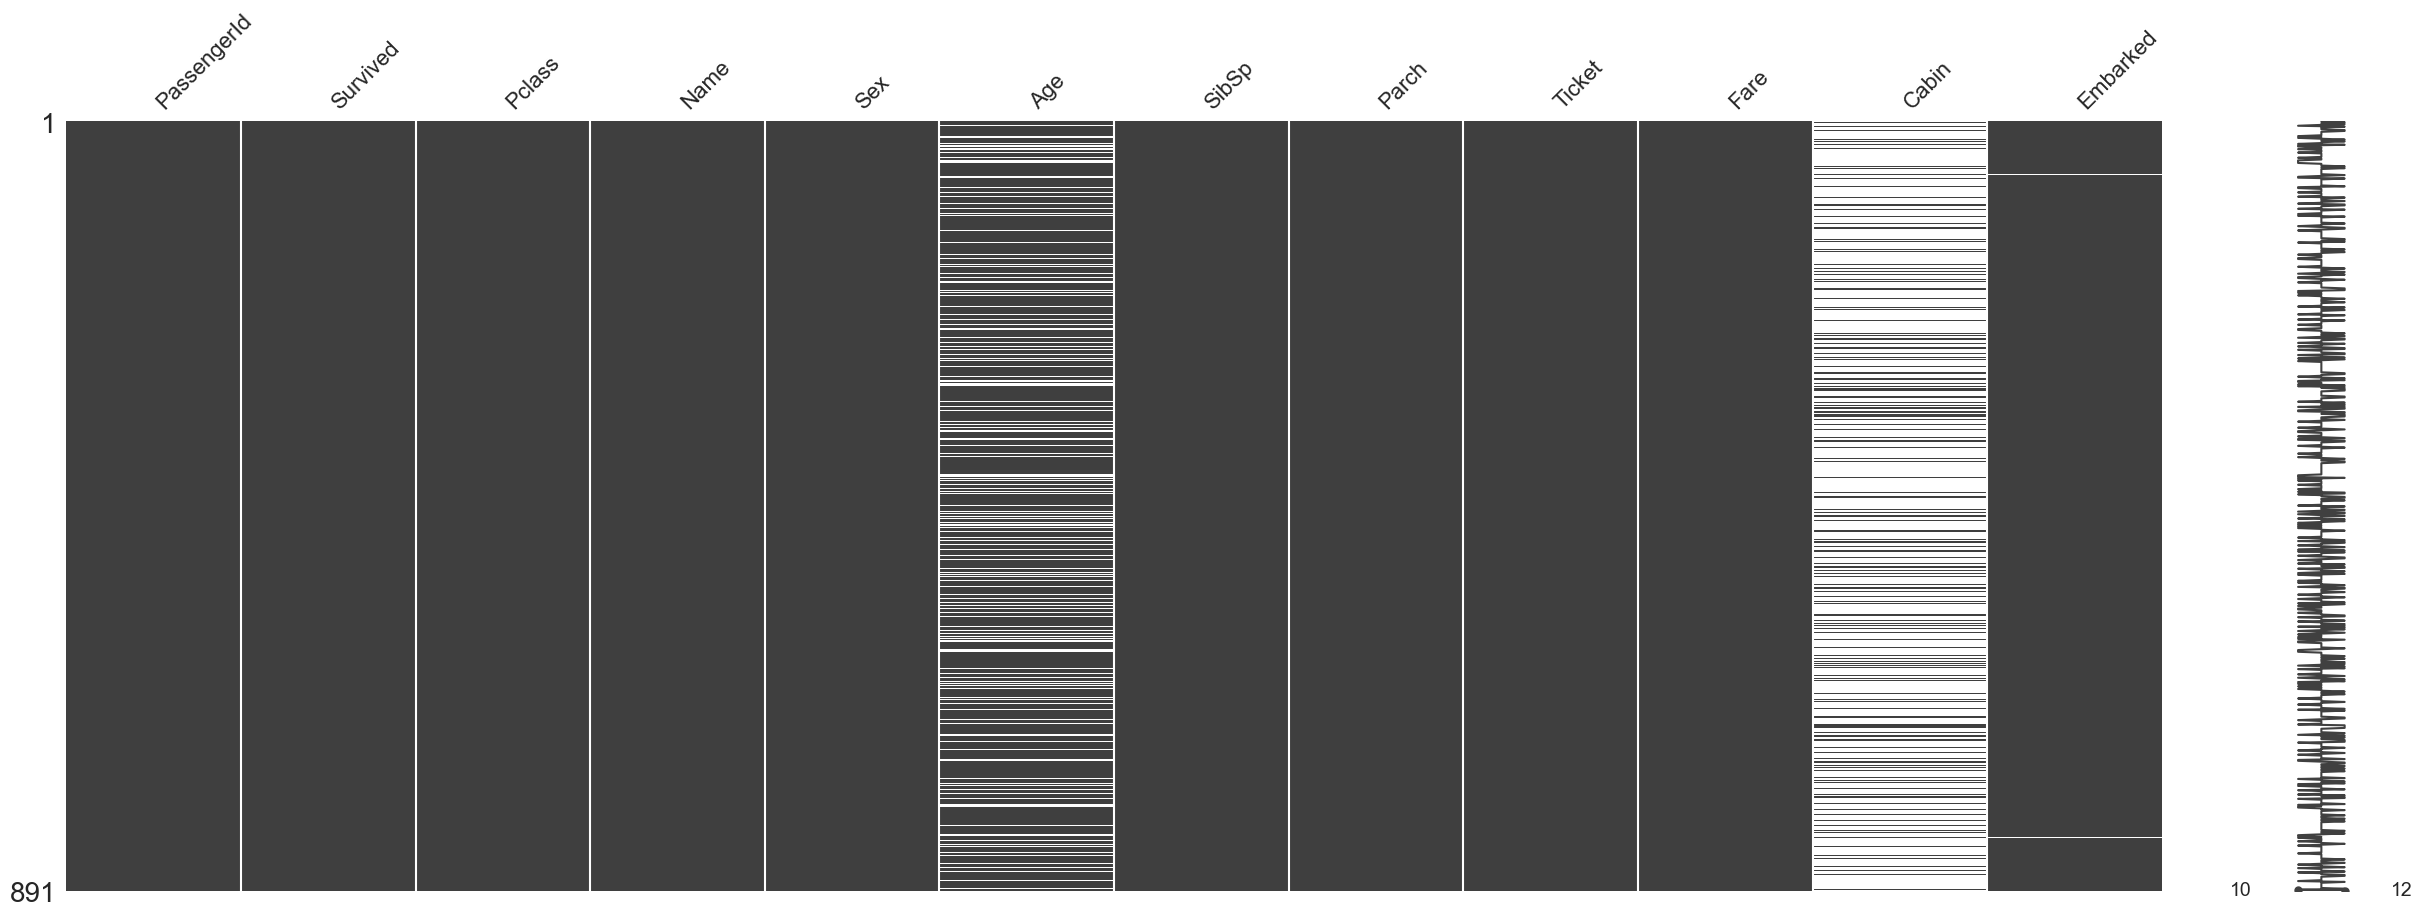

In [12]:
missingno.matrix(df_train, figsize = (30,10))

## Age and cabin are missing a large amount of data 
## embarked is missing two inputs 

In [15]:
## just a different way to show how many values are missing 
df_train.isnull().sum() 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Dealing with missing values 

## cabin

In [19]:
#Missing Values of “Cabin”
#Our first task is quickly done by deleting the feature “Cabin” from the training and test dataset. Make sure to set the axis to 1 to drop the column and not every single row.

df_train = df_train.drop(['Cabin'], axis=1)
df_test = df_test.drop(['Cabin'], axis=1)

In [21]:
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C


## fare

In [24]:
#There is one missing values of “Fare” in the test dataset. 
#We will use the same process as we did with the missing values of “Embarked”. 
#Fist we take a closer look at the passenger with the missing value of “Fare”.

df_test[df_test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


In [26]:
 #we fill the missing value of “Fare” with the median fare for all passengers that embarked in Southampton with the passenger class 3.

median_fare = df_test[(df_test['Pclass'] == 3) & (df_test['Embarked'] == 'S')]['Fare'].median()
df_test["Fare"] = df_test["Fare"].fillna(median_fare)

## Embarked

In [29]:
df_train[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


In [31]:
#passengers that embarked from Cherbourg had a median fare of around 80 for the first passenger class. 
#Also, we already know that passengers of Cherbourg (C) have the highest survival rate with 55%

df_train["Embarked"] = df_train["Embarked"].fillna("C")

## Age

In [34]:
data = [df_train, df_test]
for dataset in data:
    mean = df_train["Age"].mean()
    std = df_test["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = df_train["Age"].astype(int)

<Axes: >

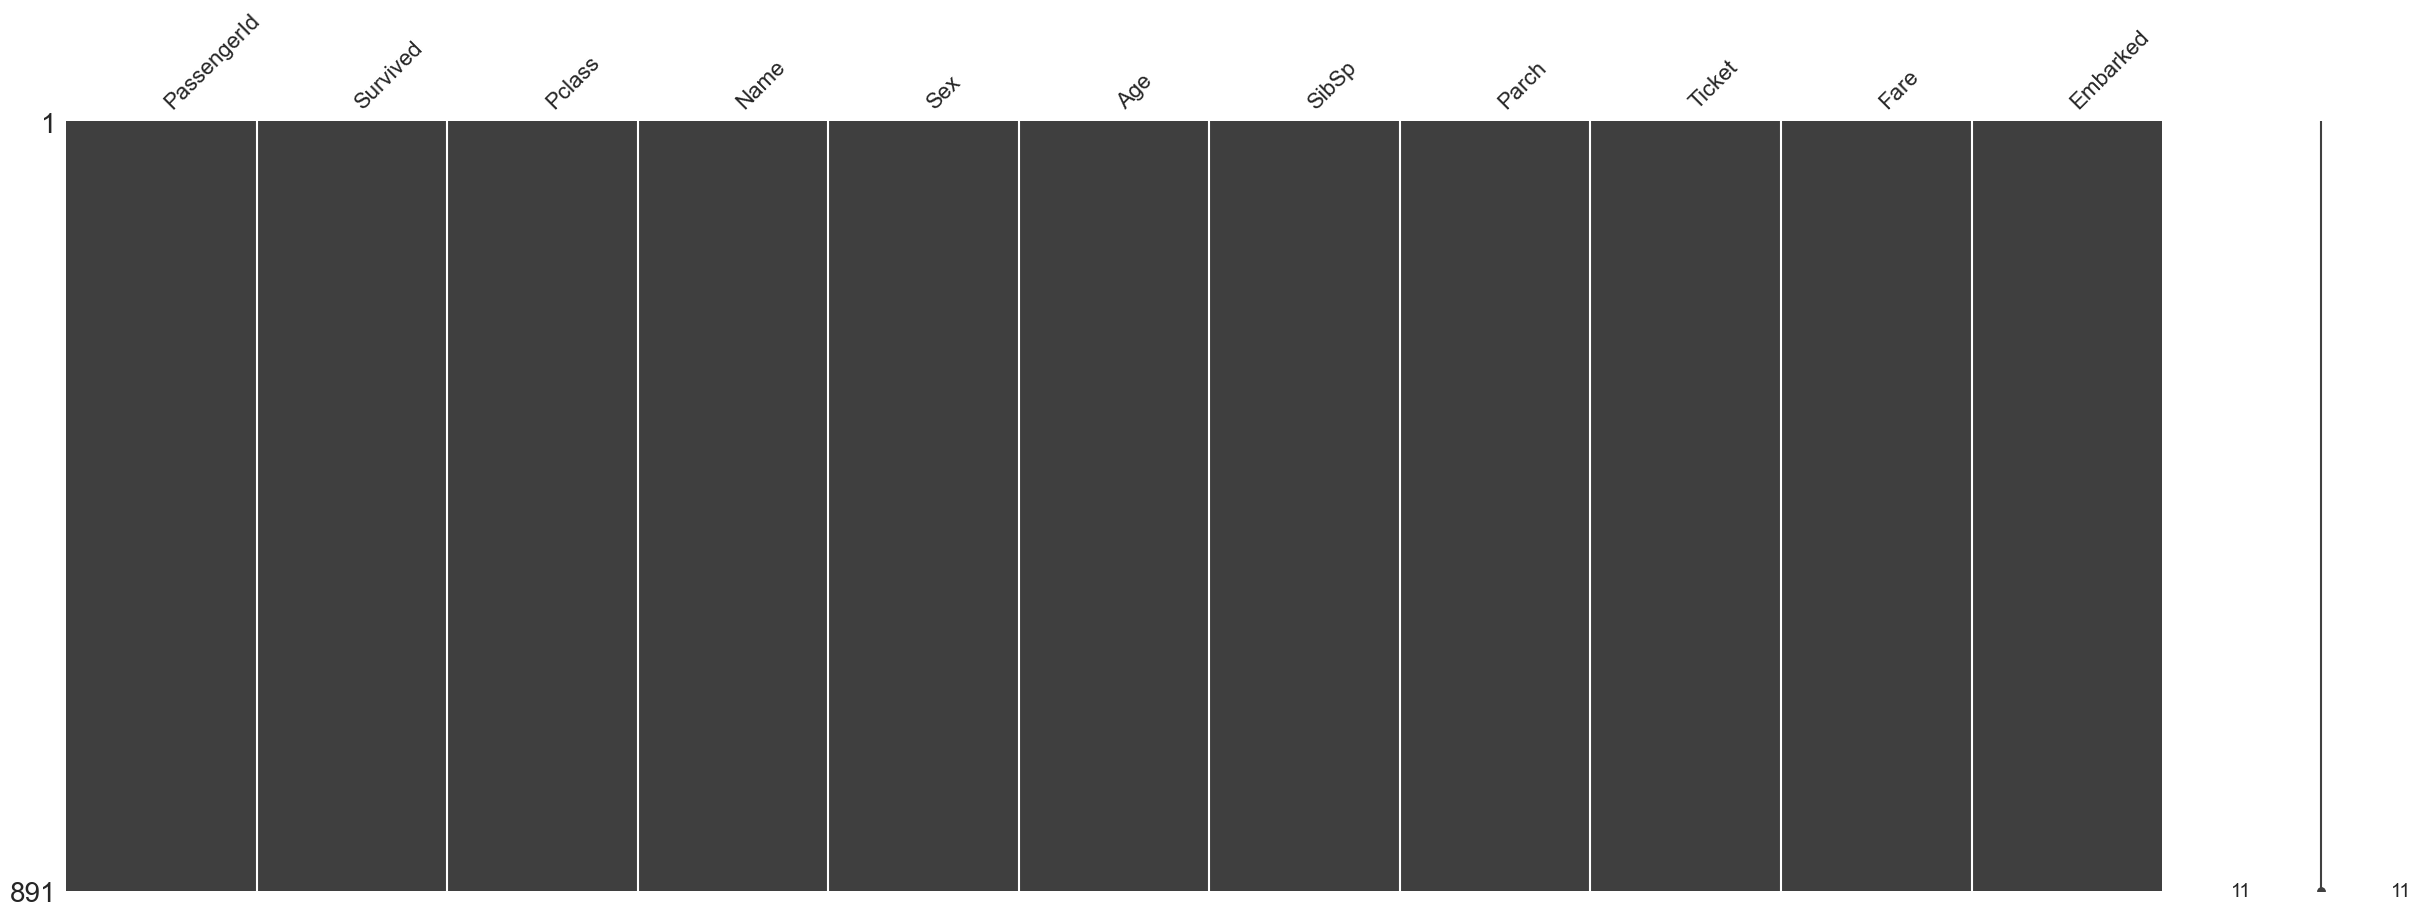

In [36]:
missingno.matrix(df_train, figsize = (30,10))

## First were going to add the necessary columns to out subset dataframe
 - add survived, class, sex, SibSp, and Parch to subset dataframe as given

In [39]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continous variables

In [41]:
# adding the survived column 
df_bin['Survived'] = df_train['Survived']
df_con['Survived'] = df_train['Survived']

In [43]:
# adding the passenger class 
df_bin['Pclass'] = df_train['Pclass']
df_con['Pclass'] = df_train['Pclass']

In [45]:
# adding sex of the passenger
df_bin['Sex'] = df_train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

df_con['Sex'] = df_train['Sex']

In [47]:
# adding number of sibling / spouses the passenger has 
df_bin['SibSp'] = df_train['SibSp']
df_con['SibSp'] = df_train['SibSp']

In [49]:
df_bin['Parch'] = df_train['Parch']
df_con['Parch'] = df_train['Parch']

In [51]:
# Adding ticket price for each passenger 
df_bin['Ticket'] = df_train['Ticket']
df_con['Ticket'] = df_train['Ticket']


In [53]:
df_con['Fare'] = df_train['Fare'] 
df_bin['Fare'] = pd.cut(df_train['Fare'], bins=5) # discretised 

In [55]:
df_bin['Age'] = pd.cut(df_train['Age'], 10) # bucketed/binned into different categories
df_con['Age'] = df_train['Age'] # non-bucketed

In [57]:
df_bin['Embarked'] = df_train['Embarked']
df_con['Embarked'] = df_train['Embarked']

In [59]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Ticket,Fare,Age,Embarked
0,0,3,male,1,0,A/5 21171,7.2500,22,S
1,1,1,female,1,0,PC 17599,71.2833,38,C
2,1,3,female,0,0,STON/O2. 3101282,7.9250,26,S
3,1,1,female,1,0,113803,53.1000,35,S
4,0,3,male,0,0,373450,8.0500,35,S


<Axes: >

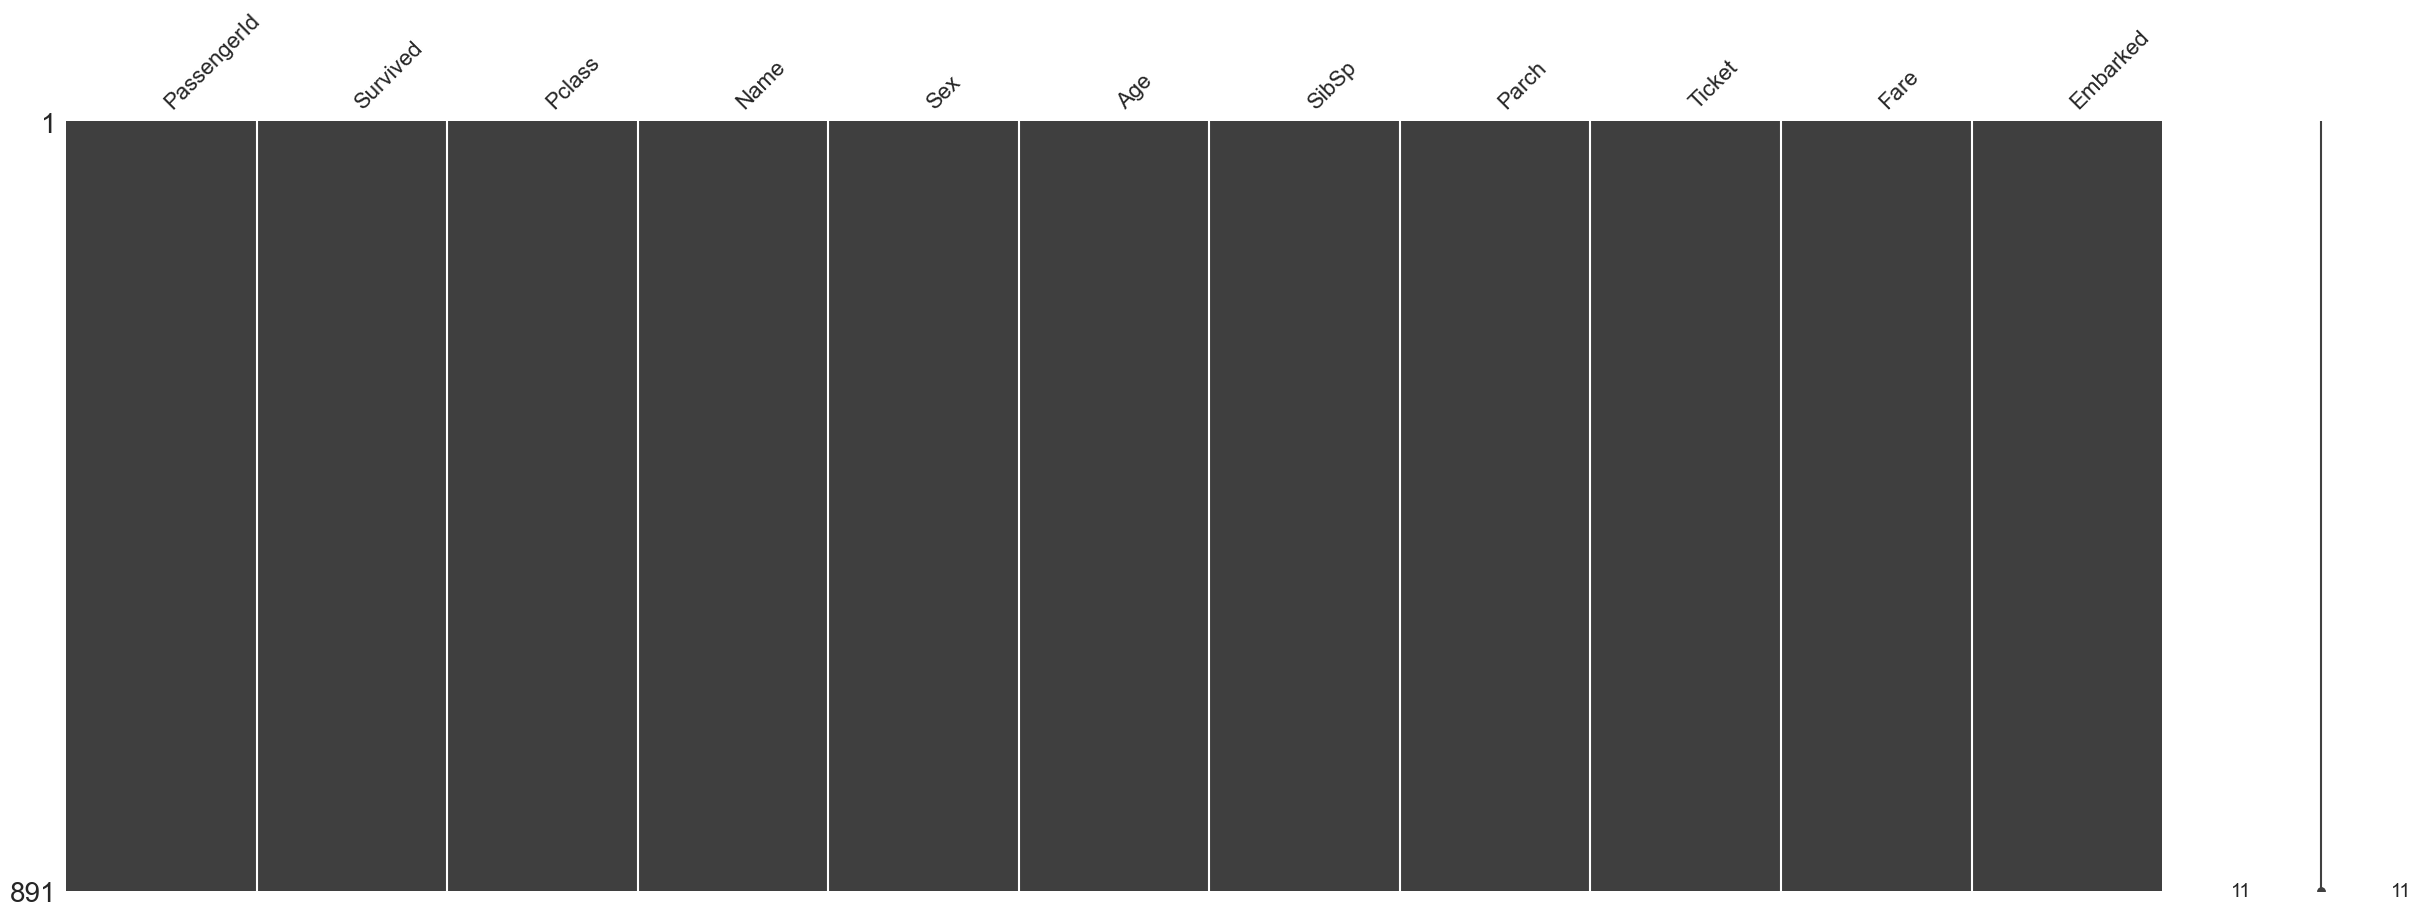

In [61]:
missingno.matrix(df_train, figsize = (30,10))

## Feature encoding 
- Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models

In [64]:
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

#convert all boolean columns to integers 1 or 0 after on-hot encoding 
df_bin_enc = df_bin_enc.astype(int)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,"Age_(24.0, 32.0]","Age_(32.0, 40.0]","Age_(40.0, 48.0]","Age_(48.0, 56.0]","Age_(56.0, 64.0]","Age_(64.0, 72.0]","Age_(72.0, 80.0]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [66]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Ticket,Fare,Age,Embarked
0,0,3,male,1,0,A/5 21171,7.2500,22,S
1,1,1,female,1,0,PC 17599,71.2833,38,C
2,1,3,female,0,0,STON/O2. 3101282,7.9250,26,S
3,1,1,female,1,0,113803,53.1000,35,S
4,0,3,male,0,0,373450,8.0500,35,S


In [68]:
df_con_enc = df_con.apply(LabelEncoder().fit_transform)

df_con_enc.head(4)

,Survived,Pclass,Sex,SibSp,Parch,Ticket,Fare,Age,Embarked
0,0,2,1,1,0,523,18,22,2
1,1,0,0,1,0,596,207,38,0
2,1,2,0,0,0,669,41,26,2
3,1,0,0,1,0,49,189,35,2


## Machine Learning models 

In [40]:
# Seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [41]:
# Split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [42]:
selected_df.head()

,Survived,Pclass,Sex,SibSp,Parch,Ticket,Fare,Age,Embarked
0,0,2,1,1,0,523,18,22,2
1,1,0,0,1,0,596,207,38,0
2,1,2,0,0,0,669,41,26,2
3,1,0,0,1,0,49,189,35,2
4,0,2,1,0,0,472,43,35,2


In [43]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

## using catboost algorithm 

In [45]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float64)[0]
cat_features

array([0, 1, 2, 3, 4, 5, 6, 7])

In [46]:
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [47]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [48]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009807
0:	learn: 0.6874421	total: 70.1ms	remaining: 1m 10s
1:	learn: 0.6827227	total: 73.9ms	remaining: 36.9s
2:	learn: 0.6777742	total: 75.3ms	remaining: 25s
3:	learn: 0.6725390	total: 77.2ms	remaining: 19.2s
4:	learn: 0.6668159	total: 80ms	remaining: 15.9s
5:	learn: 0.6614565	total: 82.6ms	remaining: 13.7s
6:	learn: 0.6582194	total: 83.6ms	remaining: 11.9s
7:	learn: 0.6532565	total: 86.8ms	remaining: 10.8s
8:	learn: 0.6477489	total: 89.4ms	remaining: 9.85s
9:	learn: 0.6430023	total: 91.1ms	remaining: 9.02s
10:	learn: 0.6386338	total: 94.2ms	remaining: 8.47s
11:	learn: 0.6342966	total: 96.6ms	remaining: 7.95s
12:	learn: 0.6295143	total: 98.7ms	remaining: 7.49s
13:	learn: 0.6257352	total: 99.6ms	remaining: 7.01s
14:	learn: 0.6220166	total: 102ms	remaining: 6.67s
15:	learn: 0.6176404	total: 103ms	remaining: 6.32s
16:	learn: 0.6131334	total: 106ms	remaining: 6.1s
17:	learn: 0.6090605	total: 108ms	remaining: 5.87s
18:	learn: 0.6053841	total: 109ms	remaining: 5.6s
19

In [49]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
0:	learn: 0.6763548	test: 0.6801768	best: 0.6801768 (0)	total: 4.9ms	remaining: 4.89s
1:	learn: 0.6576376	test: 0.6688432	best: 0.6688432 (1)	total: 23ms	remaining: 11.5s
2:	learn: 0.6392611	test: 0.6560768	best: 0.6560768 (2)	total: 31ms	remaining: 10.3s
3:	learn: 0.6264618	test: 0.6464969	best: 0.6464969 (3)	total: 34.1ms	remaining: 8.49s
4:	learn: 0.6133665	test: 0.6369114	best: 0.6369114 (4)	total: 40.1ms	remaining: 7.97s
5:	learn: 0.5996125	test: 0.6280942	best: 0.6280942 (5)	total: 45.7ms	remaining: 7.57s
6:	learn: 0.5883809	test: 0.6204496	best: 0.6204496 (6)	total: 49.3ms	remaining: 6.99s
7:	learn: 0.5785794	test: 0.6132535	best: 0.6132535 (7)	total: 54.1ms	remaining: 6.71s
8:	learn: 0.5706019	test: 0.6067110	best: 0.6067110 (8)	total: 60.1ms	remaining: 6.62s
9:	learn: 0.5599565	test: 0.6008268	best: 0.6008268 (9)	total: 66.9ms	remaining: 6.62s
10:	learn: 0.5545206	test: 0.5960671	best: 0.5960671 (10)	total: 69.3ms	remaining: 6.23s
11:	learn: 0.5468366	t

In [50]:
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 94.16
Accuracy cross-validation 10-Fold: 82.5
Running Time: 0:01:11.683592


In [51]:
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(RandomForestClassifier(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 100.0
Accuracy CV 10-Fold: 83.61
Running Time: 0:00:07.279104


## Submission using random forest classifier 

In [53]:
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Age', 'Embarked'], dtype='object')

In [54]:
# One hot encode the columns in the test data frame (like X_train)
test_embarked_one_hot = pd.get_dummies(df_test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(df_test['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(df_test['Pclass'], 
                                   prefix='pclass')

test_parch_one_hot = pd.get_dummies(df_test['Parch'],
                                    prefix= 'parch')

test_ticket_one_hot = pd.get_dummies(df_test['Ticket' ] ,
                                     prefix= 'ticket')

test_age_one_hot = pd.get_dummies(df_test['Age'],
                                  prefix= 'age')

test_fare_one_hot = pd.get_dummies(df_test['Fare'],
                                  prefix= 'fare')


In [55]:
# Combine the test one hot encoded columns with test
test = pd.concat([df_test, 
                  test_embarked_one_hot, 
                  test_sex_one_hot,
                  test_age_one_hot,
                  test_age_one_hot,
                  test_fare_one_hot,
                  test_ticket_one_hot,
                  test_plcass_one_hot], axis=1)

In [56]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,ticket_STON/O2. 3101270,ticket_STON/OQ. 369943,ticket_W./C. 14260,ticket_W./C. 14266,ticket_W./C. 6607,ticket_W./C. 6608,ticket_W.E.P. 5734,pclass_1,pclass_2,pclass_3
0,892,3,"Kelly, Mr. James",male,22,0,0,330911,7.8292,Q,...,False,False,False,False,False,False,False,False,False,True
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,38,1,0,363272,7.0000,S,...,False,False,False,False,False,False,False,False,False,True
2,894,2,"Myles, Mr. Thomas Francis",male,26,0,0,240276,9.6875,Q,...,False,False,False,False,False,False,False,False,True,False
3,895,3,"Wirz, Mr. Albert",male,35,0,0,315154,8.6625,S,...,False,False,False,False,False,False,False,False,False,True
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,35,1,1,3101298,12.2875,S,...,False,False,False,False,False,False,False,False,False,True


In [128]:
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Age', 'Embarked'], dtype='object')

In [130]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

encoded_test = test[wanted_test_columns].apply(lambda col: LabelEncoder().fit_transform(col))
predictions = clf.predict(encoded_test)
#predictions = RandomForestClassifier.predict(test[wanted_test_columns].apply(LabelEncoder().fit_transform))

In [132]:
predictions[:20]

array([0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1])

In [134]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [136]:
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [138]:
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [140]:
submission.to_csv('../RandomForestClassifier_submission3.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [144]:
submission.to_csv('/Users/kyliemarxen/Documents/RandomForestClassifier_submission3.csv', index=False)

In [142]:
import os
print(os.path.abspath('../RandomForestClassifier_submission3.csv'))

/Users/kyliemarxen/RandomForestClassifier_submission3.csv


In [64]:
#predictions = catboost_model.predict(test[wanted_test_columns].apply(LabelEncoder().fit_transform))

In [65]:
#predictions[:20]

In [66]:
# Create a submisison dataframe and append the relevant columns
#submission = pd.DataFrame()
#submission['PassengerId'] = test['PassengerId']
#submission['Survived'] = predictions # our model predictions on the test dataset
#submission.head()

In [67]:
# Let's convert our submission dataframe 'Survived' column to ints
#submission['Survived'] = submission['Survived'].astype(int)
#print('Converted Survived column to integers.')

In [68]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
#submission.to_csv('../catboost_submission2.csv', index=False)
#print('Submission CSV is ready!')